<a href="https://colab.research.google.com/github/wilmi94/MasterThesis-AE/blob/main/notebooks/sdo_bin_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification of full-disc SDO AIA Data



In [23]:
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import subprocess

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [24]:
%%capture
pip install -U sdo-cli

In [3]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change present working directory
%cd /content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work/sdo_binclass

/content/drive/MyDrive/Academia/MSc. Aerospace Engineering - FH Wiener Neustadt/4. Master Thesis/03-Work/sdo_binclass


In [27]:
!ls -a

data  .sdo-cli


## Data Aquisition

### Event Lists
Event Catalog from *Liu et al. 2020*

In [28]:
df_cme_list = pd.read_csv(r'data/all_cme_events.csv', delimiter =';')

In [29]:
df_cme_list = pd.read_csv(r'data/cme_events.csv', delimiter =';')
df_cme_list.head()

,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,X2.2,2011-02-15T01:44Z,2011-02-15T01:56Z,2011-02-15T02:06Z,11158,377,2011-02-15T02:25:00-CME-001
1,M3.5,2011-02-24T07:23Z,2011-02-24T07:35Z,2011-02-24T07:42Z,11163,392,2011-02-24T08:00:00-CME-001
2,M3.7,2011-03-07T19:43Z,2011-03-07T20:12Z,2011-03-07T20:58Z,11164,393,2011-03-07T20:12:00-CME-001
3,M2.0,2011-03-07T13:45Z,2011-03-07T14:30Z,2011-03-07T14:56Z,11166,401,2011-03-07T14:40:00-CME-001
4,M1.5,2011-03-08T03:37Z,2011-03-08T03:58Z,2011-03-08T04:20Z,11171,415,2011-03-08T05:00:00-CME-001


In [30]:
df_cme_list.describe()

,Active Region Number,Harp Number
count,129.000000,129.000000
mean,12056.542636,4215.007752
std,434.340682,1966.436079
min,11158.000000,377.000000
25%,11748.000000,2748.000000
50%,12127.000000,4396.000000
75%,12371.000000,5692.000000
max,12685.000000,7169.000000


In [33]:
# convert time stamp
df_cme_list['Start Time'] = pd.to_datetime(df_cme_list['Start Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['Peak Time'] = pd.to_datetime(df_cme_list['Peak Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list['End Time'] = pd.to_datetime(df_cme_list['End Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_cme_list.head()

,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,X2.2,2011-02-15T01:44:00,2011-02-15T01:56:00,2011-02-15T02:06:00,11158,377,2011-02-15T02:25:00-CME-001
1,M3.5,2011-02-24T07:23:00,2011-02-24T07:35:00,2011-02-24T07:42:00,11163,392,2011-02-24T08:00:00-CME-001
2,M3.7,2011-03-07T19:43:00,2011-03-07T20:12:00,2011-03-07T20:58:00,11164,393,2011-03-07T20:12:00-CME-001
3,M2.0,2011-03-07T13:45:00,2011-03-07T14:30:00,2011-03-07T14:56:00,11166,401,2011-03-07T14:40:00-CME-001
4,M1.5,2011-03-08T03:37:00,2011-03-08T03:58:00,2011-03-08T04:20:00,11171,415,2011-03-08T05:00:00-CME-001


In [11]:
df_cme_list.describe()

,Active Region Number,Harp Number
count,129.000000,129.000000
mean,12056.542636,4215.007752
std,434.340682,1966.436079
min,11158.000000,377.000000
25%,11748.000000,2748.000000
50%,12127.000000,4396.000000
75%,12371.000000,5692.000000
max,12685.000000,7169.000000


In [34]:
df_no_cme_list = pd.read_csv(r'data/no_cme_events.csv', delimiter =';')
df_no_cme_list['Start Time'] = pd.to_datetime(df_no_cme_list['Start Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_no_cme_list['Peak Time'] = pd.to_datetime(df_no_cme_list['Peak Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_no_cme_list['End Time'] = pd.to_datetime(df_no_cme_list['End Time']).dt.strftime('%Y-%m-%dT%H:%M:%S')
df_no_cme_list.head()

,Flare Class,Start Time,Peak Time,End Time,Active Region Number,Harp Number,CME
0,M1.2,2010-05-05T17:13:00,2010-05-05T17:19:00,2010-05-05T17:22:00,11069,8,No
1,M1.0,2010-06-13T05:30:00,2010-06-13T05:39:00,2010-06-13T05:44:00,11079,49,No
2,M2.0,2010-06-12T00:30:00,2010-06-12T00:57:00,2010-06-12T01:02:00,11081,54,No
3,M1.0,2010-08-07T17:55:00,2010-08-07T18:24:00,2010-08-07T18:47:00,11093,115,No
4,M2.9,2010-10-16T19:07:00,2010-10-16T19:12:00,2010-10-16T19:15:00,11112,211,No


In [13]:
df_no_cme_list.describe()

,Active Region Number,Harp Number
count,610.000000,610.000000
mean,11863.454098,3341.144262
std,430.484073,1910.887292
min,11069.000000,8.000000
25%,11513.000000,1806.000000
50%,11906.500000,3406.500000
75%,12208.000000,4808.000000
max,12673.000000,7115.000000


### create own event list from DONKI database

see: https://ccmc.gsfc.nasa.gov/tools/DONKI/#donki-webservice-calls-api

commonly used DONKI parameters you can consider:

* `mostAccurateOnly:`

  This parameter controls whether to include only the most accurate CME data in the response. Setting it to true retrieves the most accurate CME events.
Example: `mostAccurateOnly=true`

* `speed:`

  You can specify a minimum and/or maximum CME speed to filter the results based on the speed of the CME.
Example: *speed=400&speedMax=1000* (to retrieve CMEs with speeds between 400 and 1000 km/s)

* `halfAngle:`

  This parameter allows you to filter CMEs based on the angular width or half-angle of the CMEs.
Example:` halfAngle=30` (to retrieve CMEs with a half-angle of 30 degrees)

* `catalog:`

  You can specify the catalog of the CME data to retrieve. Different catalogs may provide different types of information about CME events.
Example: `catalog=SWRC_CATALOG`

In [ ]:
# # Define the API endpoint URL
# api_url = 'https://kauai.ccmc.gsfc.nasa.gov/DONKI/WS/get/CMEAnalysis'

# # Specify the date range for CMEs you are interested in
# start_date = '2011-02-01'
# end_date = '2023-07-17'  # Set the current date or any desired end date

# # Additional parameters
# most_accurate_only = 'true'
# speed_min = '400'
# speed_max = '1000'
# half_angle = '70'
# catalog = 'ALL'

# # Compose the API request URL with the parameters
# request_url = f'{api_url}?startDate={start_date}&endDate={end_date}&mostAccurateOnly={most_accurate_only}&speed={speed_min}&speedMax={speed_max}&halfAngle={half_angle}&catalog={catalog}'

# # Send a GET request to the API
# response = requests.get(request_url)

# # Check if the request was successful (status code 200)
# if response.status_code == 200:
#     # Parse the response JSON into a DataFrame
#     cme_data = pd.DataFrame(response.json())

#     # Optional: Save the DataFrame to a CSV file
#     cme_data.to_csv('cme_data.csv', index=False)
#     print("CME data downloaded and saved successfully.")
# else:
#     print("Failed to download CME data. Please check the API or try again later.")


## Explore the Data

take the fist CME from ``` df_cme_list ``` and illustrate the image sequence.



In [42]:
def create_sdo_aia_dataset(file_path, event_list, dt, wavelength ):
  '''
  download with the help of sdo-cli AIA images
  input:
  file_path = as a string where the images should be saved
  eventlist = dataframe which provides CME data like start, peak and end time
  dt = string, time step between images (if possible), e.g. '6min'
  wavelength = string, corresponing wavelegth channel of AIA e.g. '171' for 171 Angström channel

  output:
  images (51x512) within folder
  '''

  for idx in range(event_list.shape[0]):
    start_time = event_list['Start Time'][idx]
    peak_time =  event_list['Peak Time'][idx]
    end_time =   event_list['End Time'][idx]

    command = f"sdo-cli data download --path={file_path} --start={start_time} --end={end_time} --freq={dt} --wavelength={wavelength}"
    subprocess.call(command, shell=True)
    print("\r", idx, ': downloading CME from ', start_time, end="")


In [89]:
#create_sdo_aia_dataset(file_path = './data/explor_2/', event_list = df_cme_list, dt = '6min', wavelength = '171')

In [86]:
#!sdo-cli data download --path='./data/explor_2/' --start='2011-02-15T01:44:00' --end='2010-05-05T17:22:00' --freq='1h' --wavelength='171' #original

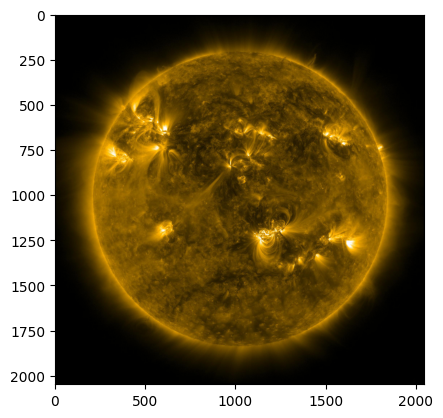

In [48]:
#inspect an image

from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

data_dir = "./data/explor/"
aia_wave = 171
images = list(Path(data_dir).rglob(f'*__{aia_wave}.jpeg'))
img_path = images[0]

src_img = Image.open(img_path)
plt.imshow(np.asarray(src_img))

In [91]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_images_with_filenames(folder_path):
    # Get the list of image filenames in the folder
    image_filenames = os.listdir(folder_path)
    num_images = len(image_filenames)

    # Calculate the number of rows and columns based on the square root of the total number of images
    num_cols = int(num_images**0.5)
    num_rows = (num_images + num_cols - 1) // num_cols

    # Set the spacing between subplots
    spacing = 0.1

    # Create a figure and subplots with appropriate dimensions
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    # Iterate over the image filenames and display them in subplots
    for i, filename in enumerate(image_filenames):
        # Get the full path to the image file
        image_path = os.path.join(folder_path, filename)

        # Load the image using Matplotlib
        img = mpimg.imread(image_path)

        # Get the current subplot
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]

        # Display the image and set the subplot title as the filename
        ax.imshow(img)
        ax.set_title(filename)

        # Remove axis ticks and labels
        ax.axis('off')

        # Set the aspect ratio of each subplot to 'equal'
        ax.set_aspect('equal')

    # Adjust the spacing between subplots
    fig.subplots_adjust(wspace=spacing, hspace=spacing)

    # Show the plot
    plt.show()


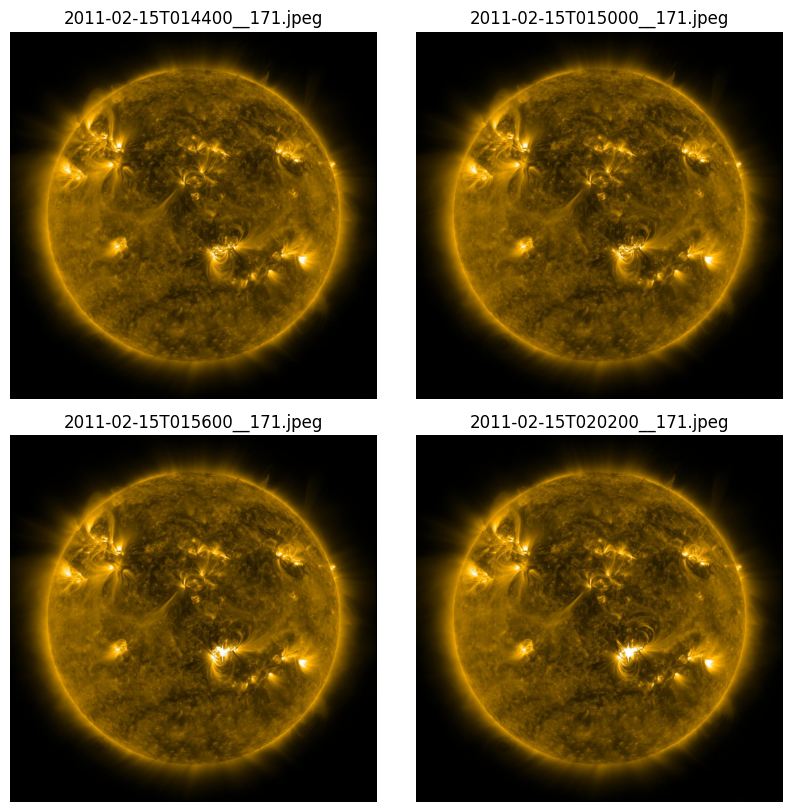

In [92]:
folder_path = "./data/explor/"
display_images_with_filenames(folder_path)

In [105]:
# Start: 2011-02-15T01:44:00	>> new start: 24h before 2011-02-14T01:44:00
# Peak:  2011-02-15T01:56:00
# End:   2011-02-15T02:06:00
!sdo-cli data download --path='./data/explor_2011-02-15T01:56:00_720/' --start='2011-02-14T01:44:00' --end='2011-02-16T02:06:00' --freq='720min' --wavelength='171' #- 24h

2023-07-18 22:29:04,615 numexpr.utils    INFO NumExpr defaulting to 2 threads.
2023-07-18 22:29:08,608 sdo.cli          INFO Starting to download images...
2023-07-18 22:29:08,614 sdo.cli          INFO loading data for 5 images between 2011-02-14 01:44:00 and 2011-02-16 02:06:00 for wavelengths ('171',)
100% 5/5 [00:01<00:00,  3.99it/s]


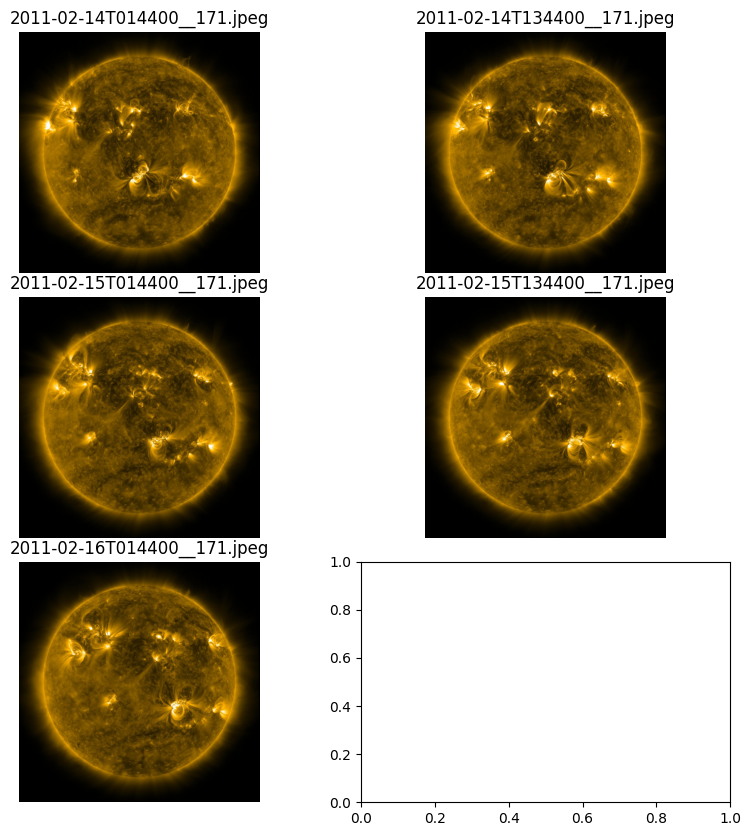

In [106]:
folder_path_2 = './data/explor_2011-02-15T01:56:00_720/'
display_images_with_filenames(folder_path_2)

## Create Dataset

In [ ]:
# create positive class, i.e. CMEs which are related to Flares
#create_sdo_aia_dataset(file_path = './data/BinClass/positive/', event_list = df_cme_list, dt = '60min', wavelength = '171')

In [ ]:
!sdo-cli data resize --path='./data/BinClass/positive/' --targetpath='./data/BinClass/positive_256' --wavelength='171' --size=256

2023-07-18 18:41:49,798 numexpr.utils    INFO NumExpr defaulting to 2 threads.
2023-07-18 18:41:52,552 sdo.cli          INFO Starting to generate resized images...
2023-07-18 18:41:52,563 sdo.cli          INFO converting 172 images


In [ ]:
# create positive class, i.e. CMEs which are NOT related to Flares
create_sdo_aia_dataset(file_path = './data/BinClass/negative/', event_list = df_no_cme_list, dt = '60min', wavelength = '171')

 609 : downloading CME from  2017-09-05T03:42:00

In [ ]:
!sdo-cli data resize --path='./data/BinClass/negative/' --targetpath='./data/BinClass/negative_256' --wavelength='171' --size=256

2023-07-18 20:12:43,288 numexpr.utils    INFO NumExpr defaulting to 2 threads.
2023-07-18 20:12:46,433 sdo.cli          INFO Starting to generate resized images...
2023-07-18 20:12:46,461 sdo.cli          INFO converting 627 images


In [ ]:
import os
import random
import shutil

def split_dataset(input_dir, output_dir, test_ratio, val_ratio):
    # Create output directories for train, test, and validation
    train_dir = os.path.join(output_dir, 'train')
    test_dir = os.path.join(output_dir, 'test')
    val_dir = os.path.join(output_dir, 'validation')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Get the list of class folders in the input directory
    class_folders = os.listdir(input_dir)

    for class_folder in class_folders:
        # Get the path to the class folder
        class_path = os.path.join(input_dir, class_folder)

        # Get the list of image filenames in the class folder
        image_filenames = os.listdir(class_path)

        # Shuffle the image filenames randomly
        random.shuffle(image_filenames)

        # Calculate the number of images for testing and validation
        num_images = len(image_filenames)
        num_test_images = int(num_images * test_ratio)
        num_val_images = int(num_images * val_ratio)

        # Split the image filenames into train, test, and validation sets
        train_images = image_filenames[num_test_images + num_val_images:]
        test_images = image_filenames[:num_test_images]
        val_images = image_filenames[num_test_images:num_test_images + num_val_images]

        # Copy images to the corresponding directories
        for image_filename in train_images:
            src = os.path.join(class_path, image_filename)
            dst = os.path.join(train_dir, class_folder, image_filename)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)

        for image_filename in test_images:
            src = os.path.join(class_path, image_filename)
            dst = os.path.join(test_dir, class_folder, image_filename)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)

        for image_filename in val_images:
            src = os.path.join(class_path, image_filename)
            dst = os.path.join(val_dir, class_folder, image_filename)
            os.makedirs(os.path.dirname(dst), exist_ok=True)
            shutil.copy(src, dst)


In [ ]:
input_dir = './data/BinClass' #'/path/to/original_dataset'
output_dir = './data/BinClass/ #'/path/to/split_dataset'
test_ratio = 0.2  # 20% for testing
val_ratio = 0.1  # 10% for validation

split_dataset(input_dir, output_dir, test_ratio, val_ratio)


## ConvNet binary classifier

In [ ]:
# Set the paths to the image folders
positive_folder = '/data/positive_256'
negative_folder = '/data/negative_256'

# Set the image dimensions and batch size
img_width, img_height = 100, 100
batch_size = 32

# Create data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    '/data',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/data',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Build the ConvNet model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=10, validation_data=validation_generator)

# Save the trained model
model.save('cme_classifier.h5')


FileNotFoundError: ignored